# NSF Research Awards Abstracts

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook is in charge of the analysis and development of a forecasting model for analyzing summaries

In [2]:
import os
import re
import io
import zipfile
import xml.etree.ElementTree as ET

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [3]:
class XMLsProcessor:
    """
    Natural Languague Processing
    """

    def parse_xml(self, xml_string):
        """
        Function to parse the XML

        Args:
            * xml_string (str)
        """
        root = ET.fromstring(xml_string)
        return root

    def clean_text(self, text):
        """
        Function to clear the text

        Args:
            * text (str)
        """
        clean_html = BeautifulSoup(text, 'html.parser').get_text()
        clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_html)
        clean_text = clean_text.lower()
        clean_text = ' '.join(clean_text.split())
        return clean_text

In [6]:
class AbstractsClassification:
    """
    NSF Research Awards Abstracts Classification
    """

    def __init__(self, xml_directory, xml_processor):
        """
        Constructor method

        Args:
          * xml_directory (str)
        """
        self.xml_directory = xml_directory
        self.xml_processor = xml_processor
        self.data_list = []
        self.text_vectors = None
        self.model = None

    def load_data(self):
        """
        Load abstracts dataset
        """
        url = "https://www.nsf.gov/awardsearch/download?DownloadFileName=2020&All=true"
        try:
            response = requests.get(url)
            if response.status_code == 200:
                with zipfile.ZipFile(io.BytesIO(response.content), "r") as zip_file:
                    zip_file.extractall(self.xml_directory)
                print("The ZIP file has been downloaded and unzipped successfully.")
            else:
                print("Error downloading ZIP file. Status code:", response.status_code)
        except Exception as e:
            print("Error when making request:", e)

    def extract_data(self, xml_root):
        """
        Function to extract data

        Args:
            * xml_root
        """
        data = {}
        data['AwardTitle'] = xml_root.find(".//AwardTitle").text if xml_root.find(".//AwardTitle") is not None else ""
        abstract_narration = xml_root.find(".//AbstractNarration").text if xml_root.find(".//AbstractNarration") is not None else ""
        data['AbstractNarration'] = self.xml_processor.clean_text(abstract_narration) if abstract_narration else ''
        data['AwardInstrument'] = xml_root.find(".//AwardInstrument/Value").text if xml_root.find(".//AwardInstrument/Value") is not None else ""
        data['Directorate'] = xml_root.find(".//Directorate/Abbreviation").text if xml_root.find(".//Directorate/Abbreviation") is not None else ""
        data['Division'] = xml_root.find(".//Division/Abbreviation").text if xml_root.find(".//Division/Abbreviation") is not None else ""
        return data

    def read_data(self):
        """
        Read data
        """
        self.data_list = []

        for xml_file in os.listdir(self.xml_directory):
            if xml_file.endswith(".xml"):
                with open(os.path.join(self.xml_directory, xml_file), 'r', encoding='utf-8') as file:
                    xml_string = file.read()
                    xml_root = self.xml_processor.parse_xml(xml_string)
                    data = self.extract_data(xml_root)
                    self.data_list.append(data)

    def visualize_data(self):
        """
        Function to display the distribution of summary lengths
        """
        abstract_lengths = [len(item['AbstractNarration'].split()) for item in self.data_list]
        plt.hist(abstract_lengths, bins=20)
        plt.xlabel('Summary Length')
        plt.ylabel('Frequency')
        plt.title('Summary Length Distribution')
        plt.show()

    def create_TF_IDF_vectorizer(self):
        """
        Create a TF-IDF vectorizer
        """
        abstracts = [item['AbstractNarration'] for item in self.data_list]
        tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        self.text_vectors = tfidf_vectorizer.fit_transform(abstracts).toarray()

    def train_model(self, num_clusters=5):
        """
        Train a K-Means model with 5 clusters
        """
        self.model = KMeans(n_clusters=num_clusters, random_state=42)
        self.model.fit(self.text_vectors)

    def cluster_documents(self):
        """
        Function to group documents into clusters
        """
        clusters = self.model.predict(self.text_vectors)
        for i, cluster_id in enumerate(clusters):
            self.data_list[i]['Cluster'] = cluster_id
        return self.data_list

    def run(self):
        self.load_data()
        self.read_data()
        self.visualize_data()
        self.create_TF_IDF_vectorizer()
        self.train_model()
        clustered_data = self.cluster_documents()

        for cluster_id in range(len(set([item['Cluster'] for item in clustered_data]))):
            cluster_items = [item['AwardTitle'] for item in clustered_data if item['Cluster'] == cluster_id]
            print(f'Cluster {cluster_id + 1}:')
            print('\n'.join(cluster_items))
            print('\n')


The ZIP file has been downloaded and unzipped successfully.


<ipython-input-3-aa5c7a84b7c7>:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_html = BeautifulSoup(text, 'html.parser').get_text()


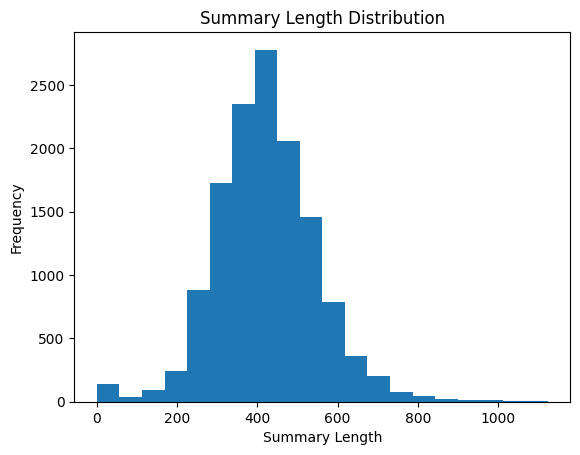

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 1:
Excellence in Research: Mathematical Analysis of the Prevention of HIV with PrEP and HAART Treatment
Doctoral Dissertation Research: Suicide Survival Narratives: How Social Statuses Affect Survivors' Cultural Narratives about Suicide Experiences
Doctoral Dissertation Research: Impact of Geography and Social Ties on Health and Well-being
RAPID/Collaborative Research: Households Immediate Response During a Night Time Earthquake
III: Small: Data-Driven Control of Epidemic Processes over Complex Dynamic Networks
US-UK Collaboration: Integrating ecology, epidemiology, and human interests to guide strategic management of zoonoses in complex wildlife reservoirs
US-UK Collab: Heterogeneities, Diversity and the Evolution of Infectious Disease
A novel integration of fine scale ecological data, high-resolution precision mapping, and regional network modeling to investigate environmental drivers of schistosomiasis dynamics
SBIR Phase I:  Automated Medical Supply Dispenser to Decrease Sp

In [7]:
# Set the XML directory
xml_directory = "/content/drive/MyDrive/nsf_abstracts"

# Initialize the XMLsProcessor
xml_processor = XMLsProcessor()

# Initialize the AbstractsClassification
abst_class = AbstractsClassification(xml_directory, xml_processor)

# Run the classification process
abst_class.run()